In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import reedsolo as rs
from reedsolo import ReedSolomonError

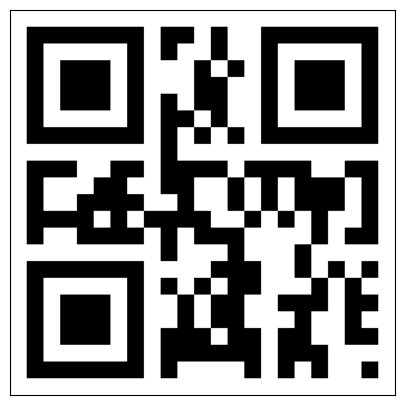

In [2]:
img = cv2.imread("04-Black-mirror.png")
img = 255 - img
_, img = cv2.threshold(img, 200, 255, cv2.THRESH_BINARY)
img = cv2.flip(img, 1)
fig = plt.figure(figsize=(5, 5));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img, cmap='gray');

(21, 21)


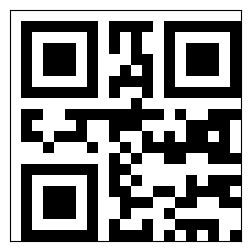

In [9]:
#_, img4 = cv2.threshold(cv2.imread("04-Black-mirror.png", cv2.IMREAD_GRAYSCALE), 128, 255, cv2.THRESH_BINARY);

img4 = cv2.imread("04-Black-mirror.png", cv2.IMREAD_GRAYSCALE)

##Invert the grayscale image
inverted_img = cv2.bitwise_not(img4) 
#rotated_img= cv2.rotate(inverted_img, cv2.ROTATE_180)

rotated_img = cv2.rotate(inverted_img, cv2.ROTATE_90_CLOCKWISE)
rotated_img = cv2.rotate(rotated_img, cv2.ROTATE_180)

start_row = -1
start_col = -1
end_row = -1
end_col = -1

for row_index, row in enumerate(img4):
    if (row != 255).any():
        start_row = row_index
        break

for row_index, row in enumerate(img4[::-1]):
    if (row != 255).any():
        end_row = img4.shape[0] - row_index
        break

for col_index, col in enumerate(cv2.transpose(img4)):
    if (col != 255).any():
        start_col = col_index
        break

for col_index, col in enumerate(cv2.transpose(img4)[::-1]):
    if (col != 255).any():
        end_col = img4.shape[1] - col_index
        break

img_4_no_quiet_zone = rotated_img[start_row:end_row, start_col:end_col]

# Alternative method to get the grid directly
# I directly resize it to 21x21 and use something like the replacement downscaling geometric transformation
# So for each collection of pixels, only one pixel survives, and since this is a perfect test case, it works
# In non-perfect test cases, you'd have needed to do some more steps to ensure correct replacement is done
img_4_21x21_grid = cv2.resize(img_4_no_quiet_zone, (21, 21), interpolation=cv2.INTER_NEAREST) // 255

fig = plt.figure(figsize=(3, 3));
plt.xticks([], []);
plt.yticks([], []);
plt.imshow(img_4_21x21_grid, cmap='gray');
print(img_4_21x21_grid.shape)

In [10]:
# Dictionary of all masks and their equivalent formulae
# P.S. I modified them to account for that I skipped the FEC mask part above
# If you will do it, do not XOR the mask if you wish to use this MASKS table
MASKS = {
    "000": lambda i, j: (i * j) % 2 + (i * j) % 3 == 0,
    "001": lambda i, j: (i // 2 + j // 3) % 2 == 0,
    "010": lambda i, j: ((i + j) % 2 + (i * j) % 3) % 2 == 0,
    "011": lambda i, j: ((i * j) % 2 + (i * j) % 3) % 2 == 0,
    "100": lambda i, j: i % 2 == 0,
    "101": lambda i, j: (i + j) % 2 == 0,
    "110": lambda i, j: (i + j) % 3 == 0,
    "111": lambda i, j: j % 3 == 0,
}
# Enum for the different directions of reading blocks in the QR code
# The number indicates how many bytes are in this block
UP8, UP4, DOWN8, DOWN4, CW8, CCW8 = range(6)

In [11]:
# A more general apply_mask function (still works the same way)
def apply_mask_general(data_start_i, data_start_j, data, mask, direction):
    result = []
    row_offsets = []
    col_offsets = []
    mask_str = ''.join([str(c) for c in mask])
    if (direction in [UP8, UP4]):
        row_offsets = [0,  0, -1, -1, -2, -2, -3, -3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction in [DOWN8, DOWN4]):
        row_offsets = [0,  0,  1,  1,  2,  2,  3,  3]
        col_offsets = [0, -1,  0, -1,  0, -1,  0, -1]
    if (direction == CW8):
        row_offsets = [0,  0,  1,  1,  1,  1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    if (direction == CCW8):
        row_offsets = [0,  0, -1, -1, -1, -1,  0,  0]
        col_offsets = [0, -1,  0, -1, -2, -3, -2, -3]
    for i, j in zip(row_offsets, col_offsets):
        cell_bit = bool(data[data_start_i+i, data_start_j+j])
        mask_bit = MASKS[mask_str](data_start_i+i, data_start_j+j)
        # Modules corresponding to the dark areas of the mask are inverted.
        result.append(int(not cell_bit if mask_bit else cell_bit))
    return result[:4] if direction in [UP4, DOWN4] else result

In [12]:
img4_21x21_grid_inv = 1 - img_4_21x21_grid
ecl = img4_21x21_grid_inv[8, 0:2]
mask = img4_21x21_grid_inv[8, 2:5]
enc_bits = apply_mask_general(21-1, 21-1, img4_21x21_grid_inv, mask, UP4)
len_bits = apply_mask_general(21-3, 21-1, img4_21x21_grid_inv, mask, UP8)
len_int = int(''.join([str(bit) for bit in len_bits]), 2)
print(f'ECL = {ecl}\nMASK = {mask}\nENC = {enc_bits}\nLEN = {len_bits} = {len_int} data symbols, each consisting of 8 bits')

ECL = [0 0]
MASK = [0 0 0]
ENC = [1, 0, 0, 0]
LEN = [1, 1, 1, 1, 0, 1, 0, 1] = 245 data symbols, each consisting of 8 bits


In [13]:
block_starting_indices = [
    [21-7,  21-1,  UP8],
    [21-11, 21-1,  CCW8],
    [21-10, 21-3,  DOWN8],
    [21-6,  21-3,  DOWN8],
    [21-2,  21-3,  CW8],
    [21-3,  21-5,  UP8],
    [21-7,  21-5,  UP8],
    [21-11, 21-5,  CCW8],
    [21-10, 21-7,  DOWN8],
    [21-6,  21-7,  DOWN8],
    [21-2,  21-7,  CW8],
    [21-3,  21-9,  UP8],
    [21-7,  21-9,  UP8],
    [21-11, 21-9,  UP8],
    [21-16, 21-9,  UP8],
    [21-20, 21-9,  CCW8],
    [21-19, 21-11, DOWN8],
    [21-14, 21-11, DOWN4],  # Special 4-byte block, reserved for END (if exists!)
    [21-12, 21-11, DOWN8],
    [21-8,  21-11, DOWN8],
    [21-4,  21-11, DOWN8],
    [21-9,  21-13, UP8],
    [21-12, 21-16, DOWN8],
    [21-9,  21-18, UP8],
    [21-12, 21-20, DOWN8],
]

In [16]:
message_bits = []
message_bits.extend(enc_bits)
message_bits.extend(len_bits)
# First, let's read the data bytes, starting from the very first byte after enc and len
byte_index = 0
for _ in range(len_int):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img4_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1
# After finishing all the characters, the next 4 bits are expected to be '0000'
start_i, start_j, dir = block_starting_indices[byte_index]
bits = apply_mask_general(start_i, start_j, img4_21x21_grid_inv, mask, dir)
message_bits.extend(bits)
bit_string = ''.join([str(bit) for bit in bits])
print(f'{bit_string} (=END) -- the NULL TERMINATOR, followed by padding and/or ECC')
byte_index += 1
# Let's see what the bytes that follow look like
# There supposedly remain 25-len-1 bytes to be read
for _ in range(25 - len_int - 1):
    start_i, start_j, dir = block_starting_indices[byte_index]
    bits = apply_mask_general(start_i, start_j, img4_21x21_grid_inv, mask, dir)
    message_bits.extend(bits)
    bit_string = ''.join([str(bit) for bit in bits])
    alpha_char = chr(int(bit_string, 2))
    print(f'{bit_string} (={int(bit_string, 2):03d}) = {alpha_char}')
    byte_index += 1

00111001 (=057) = 9
01010001 (=081) = Q
11000010 (=194) = Â
00011011 (=027) = 
01001111 (=079) = O
11111100 (=252) = ü
01010010 (=082) = R
11111100 (=252) = ü
10001000 (=136) = 
10110001 (=177) = ±
00100100 (=036) = $
11011011 (=219) = Û
10110100 (=180) = ´
11011100 (=220) = Ü
00011111 (=031) = 
01111111 (=127) = 
00110110 (=054) = 6
0101 (=005) = 
01100101 (=101) = e
01101110 (=110) = n
10010110 (=150) = 
10000001 (=129) = 
11001111 (=207) = Ï
01011000 (=088) = X
11111111 (=255) = ÿ


IndexError: list index out of range